Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        3.3e+05 s    Elapsed time so far: 36.1 s


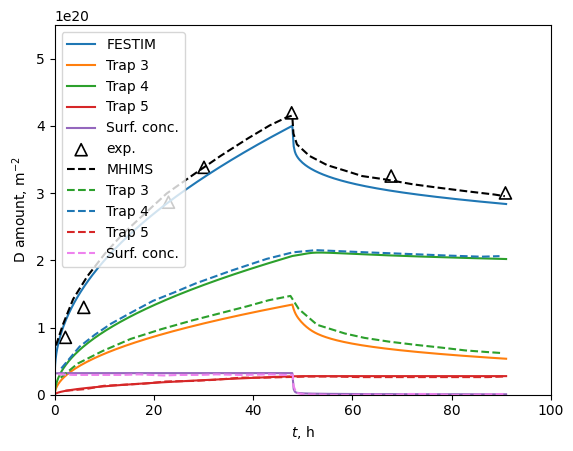

In [1]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import warnings

global n_surf

warnings.filterwarnings("ignore")

################### PARAMETERS ###################
# Exposure conditions
T_exposure = 600
t_exposure = 48 * 3600
Gamma_atom = 5.8e18

t_des = 43 * 3600

final_time = t_exposure + t_des
# Sample
L = 0.8e-3  # half thickness, m

# W properties
rho_W = 6.3e28  # W atomic concentration, m^-3
n_IS = 6 * rho_W  # concentration of interstitial sites, m^-3
n_surf = 6.9 * rho_W ** (2 / 3)  # concentration of adsorption sites, m^-2

nu0 = 1e13  # attempt frequency, s^-1
SP = 0.19
D0 = 1.93e-7 / np.sqrt(2)  # diffusivity pre-factor, m^2 s^-1
E_diff = 0.2  # diffusion activation energy, eV
lambda_IS = 110e-12  # distance between 2 IS sites, m
sigma_exc = 1.7e-21  # Cross-section for the direct abstraction, m^2
lambda_des = 1 / np.sqrt(n_surf)

# Transitions
E_bs = E_diff  # energy barrier from bulk to surface, eV
E_sb = 1.55
E_des = 0.87

################### MODEL ###################


def K_sb(T, surf_conc, t):
    return nu0 * f.exp(-E_sb / F.k_B / T)


def K_bs(T, surf_conc, t):
    return nu0 * f.exp(-E_bs / F.k_B / T)


def J_vs(T, surf_conc, t):
    G_atom = Gamma_atom * f.conditional(t <= t_exposure, 1, 0)

    phi_atom = SP * G_atom * (1 - surf_conc / n_surf)

    phi_exc = G_atom * sigma_exc * surf_conc

    phi_des = 2 * nu0 * (lambda_des * surf_conc) ** 2 * f.exp(-2 * E_des / F.k_B / T)
    return phi_atom - phi_exc - phi_des


W_model = F.Simulation(log_level=40)

# Mesh
vertices = np.concatenate(
    [
        np.linspace(0, 2e-8, num=101),
        np.linspace(2e-8, 3e-6, num=250),
        np.linspace(3e-6, L, num=500),
    ]
)

W_model.mesh = F.MeshFromVertices(np.sort(vertices))

# Materials
tungsten = F.Material(id=1, D_0=D0, E_D=E_diff)
W_model.materials = tungsten

"""distr = sp.Piecewise(
    (1, F.x <= 2.2e-6),
    (1 - (F.x - 2.2e-6)/0.2e-6, F.x <= 2.4e-6),
    (0, True)
    )"""
distr = 1 / (1 + sp.exp((F.x - 2.2e-6) / 2.5e-8))
traps = F.Traps(
    [
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=0.85,
            density=1e-4 * rho_W,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=1.00,
            density=1e-4 * rho_W,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=1.65,
            density=0.19e-2 * rho_W * distr,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=1.85,
            density=0.16e-2 * rho_W * distr,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=2.06,
            density=0.02e-2 * rho_W * distr,
            materials=tungsten,
        ),
    ]
)
W_model.traps = traps

W_model.T = T_exposure

my_BC = F.SurfaceKinetics(
    k_sb=K_sb,
    k_bs=K_bs,
    lambda_IS=lambda_IS,
    n_surf=n_surf,
    n_IS=n_IS,
    J_vs=J_vs,
    surfaces=[1, 2],
    initial_condition=0,
    t=F.t,
)

W_model.boundary_conditions = [my_BC]

W_model.dt = F.Stepsize(
    initial_value=1e-5,
    stepsize_change_ratio=1.2,
    max_stepsize=1000,
    dt_min=1e-6,
)

W_model.settings = F.Settings(
    absolute_tolerance=1e7,
    relative_tolerance=1e-9,
    maximum_iterations=50,
    final_time=final_time,
)

# Exports
results_folder = "./results/"

derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume(field="retention", volume=1),
        F.AdsorbedHydrogen(surface=1),
        F.TotalVolume(field="1", volume=1),
        F.TotalVolume(field="2", volume=1),
        F.TotalVolume(field="3", volume=1),
        F.TotalVolume(field="4", volume=1),
        F.TotalVolume(field="5", volume=1),
    ]
)

W_model.exports = [derived_quantities]

W_model.initialise()
W_model.run()

retention = np.array(derived_quantities[0].data) + np.array(derived_quantities[1].data)
t = np.array(derived_quantities.t)

plt.plot(t / 3600, retention, label="FESTIM")

plt.plot(t / 3600, np.array(derived_quantities[4].data), label="Trap 3")
plt.plot(t / 3600, np.array(derived_quantities[5].data), label="Trap 4")
plt.plot(t / 3600, np.array(derived_quantities[6].data), label="Trap 5")
plt.plot(t / 3600, np.array(derived_quantities[1].data), label="Surf. conc.")

# plt.plot(t/3600, np.array(derived_quantities[1].data))

exp = pd.read_csv("./exp_data.csv", header=None, skiprows=1, sep=",")

plt.scatter(
    exp[0],
    exp[1] * 1e19,
    marker="^",
    s=75,
    ec="black",
    fc="none",
    linewidths=1.2,
    label="exp.",
)

exp = pd.read_csv("./MHIMS.csv", header=None, skiprows=1, sep=",")

plt.plot(exp[0] * 2, exp[1] * 1e19, color="black", ls="dashed", label="MHIMS")

exp = pd.read_csv("./3.csv", header=None, skiprows=1, sep=",")

plt.plot(exp[0], exp[1] * 1e19, color="tab:green", ls="dashed", label="Trap 3")

exp = pd.read_csv("./4.csv", header=None, skiprows=1, sep=",")

plt.plot(exp[0], exp[1] * 1e19, color="tab:blue", ls="dashed", label="Trap 4")

exp = pd.read_csv("./5.csv", header=None, skiprows=1, sep=",")

plt.plot(exp[0], exp[1] * 1e19, color="tab:red", ls="dashed", label="Trap 5")

exp = pd.read_csv("./cs.csv", header=None, skiprows=1, sep=",")

plt.plot(exp[0], exp[1] * 1e19, color="violet", ls="dashed", label="Surf. conc.")

plt.xlabel(r"$t$, h")
plt.ylabel(r"D amount, m$^{-2}$")
plt.legend()
plt.ylim(0, 55e19)
plt.xlim(0, 100)
plt.show()